# 1. Notebook Setup

Import libraries

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import gc
from math import sqrt
import pickle
import sys

from keras_tuner import RandomSearch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

sys.path.append("/home/jovyan/Solar-Irradiance-Forecasting/src/")
import eda as eda
import helpers as hlp

Importing plotly failed. Interactive plots will not work.


Setup notebook

In [2]:
# Random seed generators
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format ="retina"  # High quality plots

# Pandas df display
pd.options.display.float_format = '{:,.2f}'.format  # Choose how many decimals to show for floats in df tables
pd.options.mode.chained_assignment = None  # default="warn"
pd.set_option("display.max_rows", 1000, "display.max_columns", 1000)  # Print more rows & columns
pd.set_option("display.float_format", lambda x: "%.3f" % x)  # Avoid scientific notation

Use GPU

In [3]:
print("Available devices: ", tf.config.experimental.list_physical_devices())

physical_gpu = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_gpu))
print("Device details: ", tf.config.experimental.get_device_details(physical_gpu[0]))
tf.config.experimental.set_memory_growth(physical_gpu[0], True)

Available devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
Device details:  {'compute_capability': (7, 5), 'device_name': 'Tesla T4'}


2023-09-06 20:42:17.599341: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-06 20:42:17.606630: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-06 20:42:17.607226: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-06 20:42:17.608333: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# 2. Loading and merging data

Load target

In [4]:
df_irradiance = pd.read_csv("../../data/Folsom_irradiance.csv", infer_datetime_format=True)
df_irradiance["timeStamp"] = pd.to_datetime(df_irradiance["timeStamp"])
df_irradiance = df_irradiance[["timeStamp", "ghi"]]
df_irradiance

,timeStamp,ghi
0,2014-01-02 08:00:00,0.000
1,2014-01-02 08:01:00,0.000
2,2014-01-02 08:02:00,0.000
3,2014-01-02 08:03:00,0.000
4,2014-01-02 08:04:00,0.000
...,...,...
1552315,2016-12-31 07:55:00,0.000
1552316,2016-12-31 07:56:00,0.000
1552317,2016-12-31 07:57:00,0.000
1552318,2016-12-31 07:58:00,0.000


Load weather data

In [5]:
df_weather = pd.read_csv("../../data/Folsom_weather.csv", infer_datetime_format=True)
df_weather["timeStamp"] = pd.to_datetime(df_weather["timeStamp"])
df_irradiance

,timeStamp,ghi
0,2014-01-02 08:00:00,0.000
1,2014-01-02 08:01:00,0.000
2,2014-01-02 08:02:00,0.000
3,2014-01-02 08:03:00,0.000
4,2014-01-02 08:04:00,0.000
...,...,...
1552315,2016-12-31 07:55:00,0.000
1552316,2016-12-31 07:56:00,0.000
1552317,2016-12-31 07:57:00,0.000
1552318,2016-12-31 07:58:00,0.000


Merge both datasets

In [6]:
df = df_irradiance.merge(df_weather, 
                         on="timeStamp", 
                         how="left", 
                         indicator=True)
display(df)
display(df["_merge"].value_counts())
df = df.drop(columns=["_merge"])

,timeStamp,ghi,air_temp,relhum,press,windsp,winddir,max_windsp,precipitation,_merge
0,2014-01-02 08:00:00,0.000,7.320,56.560,1010.000,1.800,43.610,3.700,0.000,both
1,2014-01-02 08:01:00,0.000,7.260,56.820,1010.000,2.000,48.400,3.100,0.000,both
2,2014-01-02 08:02:00,0.000,7.200,56.960,1010.000,1.900,31.800,3.700,0.000,both
3,2014-01-02 08:03:00,0.000,7.140,57.120,1010.000,1.440,38.980,2.500,0.000,both
4,2014-01-02 08:04:00,0.000,7.080,57.360,1010.000,1.840,34.210,2.800,0.000,both
...,...,...,...,...,...,...,...,...,...,...
1552315,2016-12-31 07:55:00,0.000,7.600,85.600,1001.000,1.280,237.100,2.200,0.000,both
1552316,2016-12-31 07:56:00,0.000,7.600,85.800,1000.000,3.460,171.200,6.800,0.000,both
1552317,2016-12-31 07:57:00,0.000,7.700,86.100,1001.000,1.380,213.200,2.800,0.000,both
1552318,2016-12-31 07:58:00,0.000,7.700,86.100,1001.000,1.440,168.500,2.400,0.000,both


both          1552320
left_only           0
right_only          0
Name: _merge, dtype: int64

In [7]:
del df_irradiance
del df_weather
gc.collect()

4

# 3. Data Preprocessing

In [8]:
features = ['air_temp', 'relhum', 'press', 'windsp', 'winddir', 'max_windsp', 'precipitation']
lag_steps = [10, 20]

def prepare_data(df, lag_steps):
    for i in lag_steps:
        for col in features:
            df[f'{col}_lag_{i}m'] = df[col].shift(i)
    
    # Drop rows with missing values (NaN)
    df = df.dropna()

    return df

df_fe = prepare_data(df, lag_steps)

In [9]:
num_features = len(lag_steps) * len(features) + len(features)
num_features

21

In [10]:
print(df_fe.shape)
display(df_fe.head(5))
display(df_fe.head(5))

(1551594, 23)


,timeStamp,ghi,air_temp,relhum,press,windsp,winddir,max_windsp,precipitation,air_temp_lag_10m,relhum_lag_10m,press_lag_10m,windsp_lag_10m,winddir_lag_10m,max_windsp_lag_10m,precipitation_lag_10m,air_temp_lag_20m,relhum_lag_20m,press_lag_20m,windsp_lag_20m,winddir_lag_20m,max_windsp_lag_20m,precipitation_lag_20m
20,2014-01-02 08:20:00,0.000,7.120,57.640,1010.000,1.900,46.400,3.600,0.000,7.000,57.600,1010.000,1.900,32.610,3.100,0.000,7.320,56.560,1010.000,1.800,43.610,3.700,0.000
21,2014-01-02 08:21:00,0.000,7.040,57.920,1010.000,2.000,47.200,3.500,0.000,7.000,57.640,1010.000,1.500,22.780,3.100,0.000,7.260,56.820,1010.000,2.000,48.400,3.100,0.000
22,2014-01-02 08:22:00,0.000,6.960,58.200,1010.000,2.300,50.420,3.600,0.000,7.000,57.580,1010.000,1.620,29.000,2.900,0.000,7.200,56.960,1010.000,1.900,31.800,3.700,0.000
23,2014-01-02 08:23:00,0.000,6.880,58.500,1010.000,1.900,47.600,3.400,0.000,7.000,57.540,1010.000,1.780,41.200,2.900,0.000,7.140,57.120,1010.000,1.440,38.980,2.500,0.000
24,2014-01-02 08:24:00,0.000,6.800,58.800,1010.000,1.920,48.400,3.200,0.000,7.000,57.500,1010.000,1.460,35.810,2.300,0.000,7.080,57.360,1010.000,1.840,34.210,2.800,0.000


,timeStamp,ghi,air_temp,relhum,press,windsp,winddir,max_windsp,precipitation,air_temp_lag_10m,relhum_lag_10m,press_lag_10m,windsp_lag_10m,winddir_lag_10m,max_windsp_lag_10m,precipitation_lag_10m,air_temp_lag_20m,relhum_lag_20m,press_lag_20m,windsp_lag_20m,winddir_lag_20m,max_windsp_lag_20m,precipitation_lag_20m
20,2014-01-02 08:20:00,0.000,7.120,57.640,1010.000,1.900,46.400,3.600,0.000,7.000,57.600,1010.000,1.900,32.610,3.100,0.000,7.320,56.560,1010.000,1.800,43.610,3.700,0.000
21,2014-01-02 08:21:00,0.000,7.040,57.920,1010.000,2.000,47.200,3.500,0.000,7.000,57.640,1010.000,1.500,22.780,3.100,0.000,7.260,56.820,1010.000,2.000,48.400,3.100,0.000
22,2014-01-02 08:22:00,0.000,6.960,58.200,1010.000,2.300,50.420,3.600,0.000,7.000,57.580,1010.000,1.620,29.000,2.900,0.000,7.200,56.960,1010.000,1.900,31.800,3.700,0.000
23,2014-01-02 08:23:00,0.000,6.880,58.500,1010.000,1.900,47.600,3.400,0.000,7.000,57.540,1010.000,1.780,41.200,2.900,0.000,7.140,57.120,1010.000,1.440,38.980,2.500,0.000
24,2014-01-02 08:24:00,0.000,6.800,58.800,1010.000,1.920,48.400,3.200,0.000,7.000,57.500,1010.000,1.460,35.810,2.300,0.000,7.080,57.360,1010.000,1.840,34.210,2.800,0.000


In [11]:
del df
gc.collect()

0

Train/Validation/Test split

In [12]:
# Filter
train_start = "2014-01-01"
validation_start = "2015-01-01"
test_start = "2016-01-01"

df_train = df_fe.loc[df_fe["timeStamp"] < validation_start]
df_validation = df_fe.loc[(df_fe["timeStamp"] >= validation_start) & (df_fe["timeStamp"] < test_start)]
df_test = df_fe.loc[df_fe["timeStamp"] >= test_start]

# Get list of all features
all_features_lst = list(df_fe.columns.values)
all_features_lst.remove("timeStamp")
all_features_lst.remove("ghi")

X_train, X_val, X_test = df_train[all_features_lst], df_validation[all_features_lst], df_test[all_features_lst]
y_train, y_val, y_test = df_train["ghi"], df_validation["ghi"], df_test["ghi"]

# del df_fe
# gc.collect()

Normalize input data (scaling between 0 and 1)

In [13]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.transform(X_test)

Reshape the input data for LSTM (3D shape required)

In [14]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# 4. Long-Term Forecasting Model

## a. Basic Model [v4]

In [35]:
MODEL_VERSION = "4"
is_train_new_model = True

Define the LSTM model.


In [36]:
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def lstm_model():
    # Define layers
    model = Sequential()
    model.add(LSTM(units=30, 
                   kernel_regularizer=l2(0.01), # add some L2 to discourage learning complex patterns by penalising loss function
                   return_sequences=False, # return single GHI value, not the sequence of values
                   activation='tanh',
                   recurrent_activation='sigmoid',
                   use_bias=True,
                   stateful=False,
                   input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(rate=0.10))
    model.add(Dense(1))
    
    # Define optimiser
    optimiser = Adam(learning_rate=0.01)
    model.compile(optimizer=optimiser, 
                  loss='mean_squared_error', 
                  metrics=['mean_absolute_error', root_mean_squared_error])
    
    return model

# Create LSTM model
model = lstm_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 30)                3840      
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________


Optional: restore the weights or train a new model

In [37]:
model.load_weights(f'../../output/lstm_models/lstm_v{MODEL_VERSION}.h5')
is_train_new_model = False

Train model

In [38]:
# Add early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor="val_root_mean_squared_error", 
                               patience=3, 
                               restore_best_weights=True,
                               mode="min")
csv_logger = CSVLogger(f'../../output/lstm_history/training_log_v{MODEL_VERSION}.csv', separator=',', append=False)

if is_train_new_model:
    print(f"Training a new LSTM model (version {MODEL_VERSION}).")
    history = model.fit(X_train, 
                        y_train, 
                        epochs=50,  # max number of epochs
                        batch_size=32, 
                        verbose=1, 
                        validation_data=(X_val, y_val), 
                        callbacks=[early_stopping, csv_logger])
    # Save fitted model and history
    model.save(f"../../output/lstm_models/lstm_v{MODEL_VERSION}.h5")
    with open(f"../../output/lstm_history/training_history_v{MODEL_VERSION}.pkl", "wb") as f:
        pickle.dump(history.history, f)
    
else:
    print(f"Re-loading previously trained LSTM model history (version {MODEL_VERSION}).")
    with open(f'../../output/lstm_history/training_history_v{MODEL_VERSION}.pkl', 'rb') as history_file:
        history = pickle.load(history_file)

Re-loading previously trained LSTM model history (version 4).


EOFError: Ran out of input

Plot training loss and validation loss

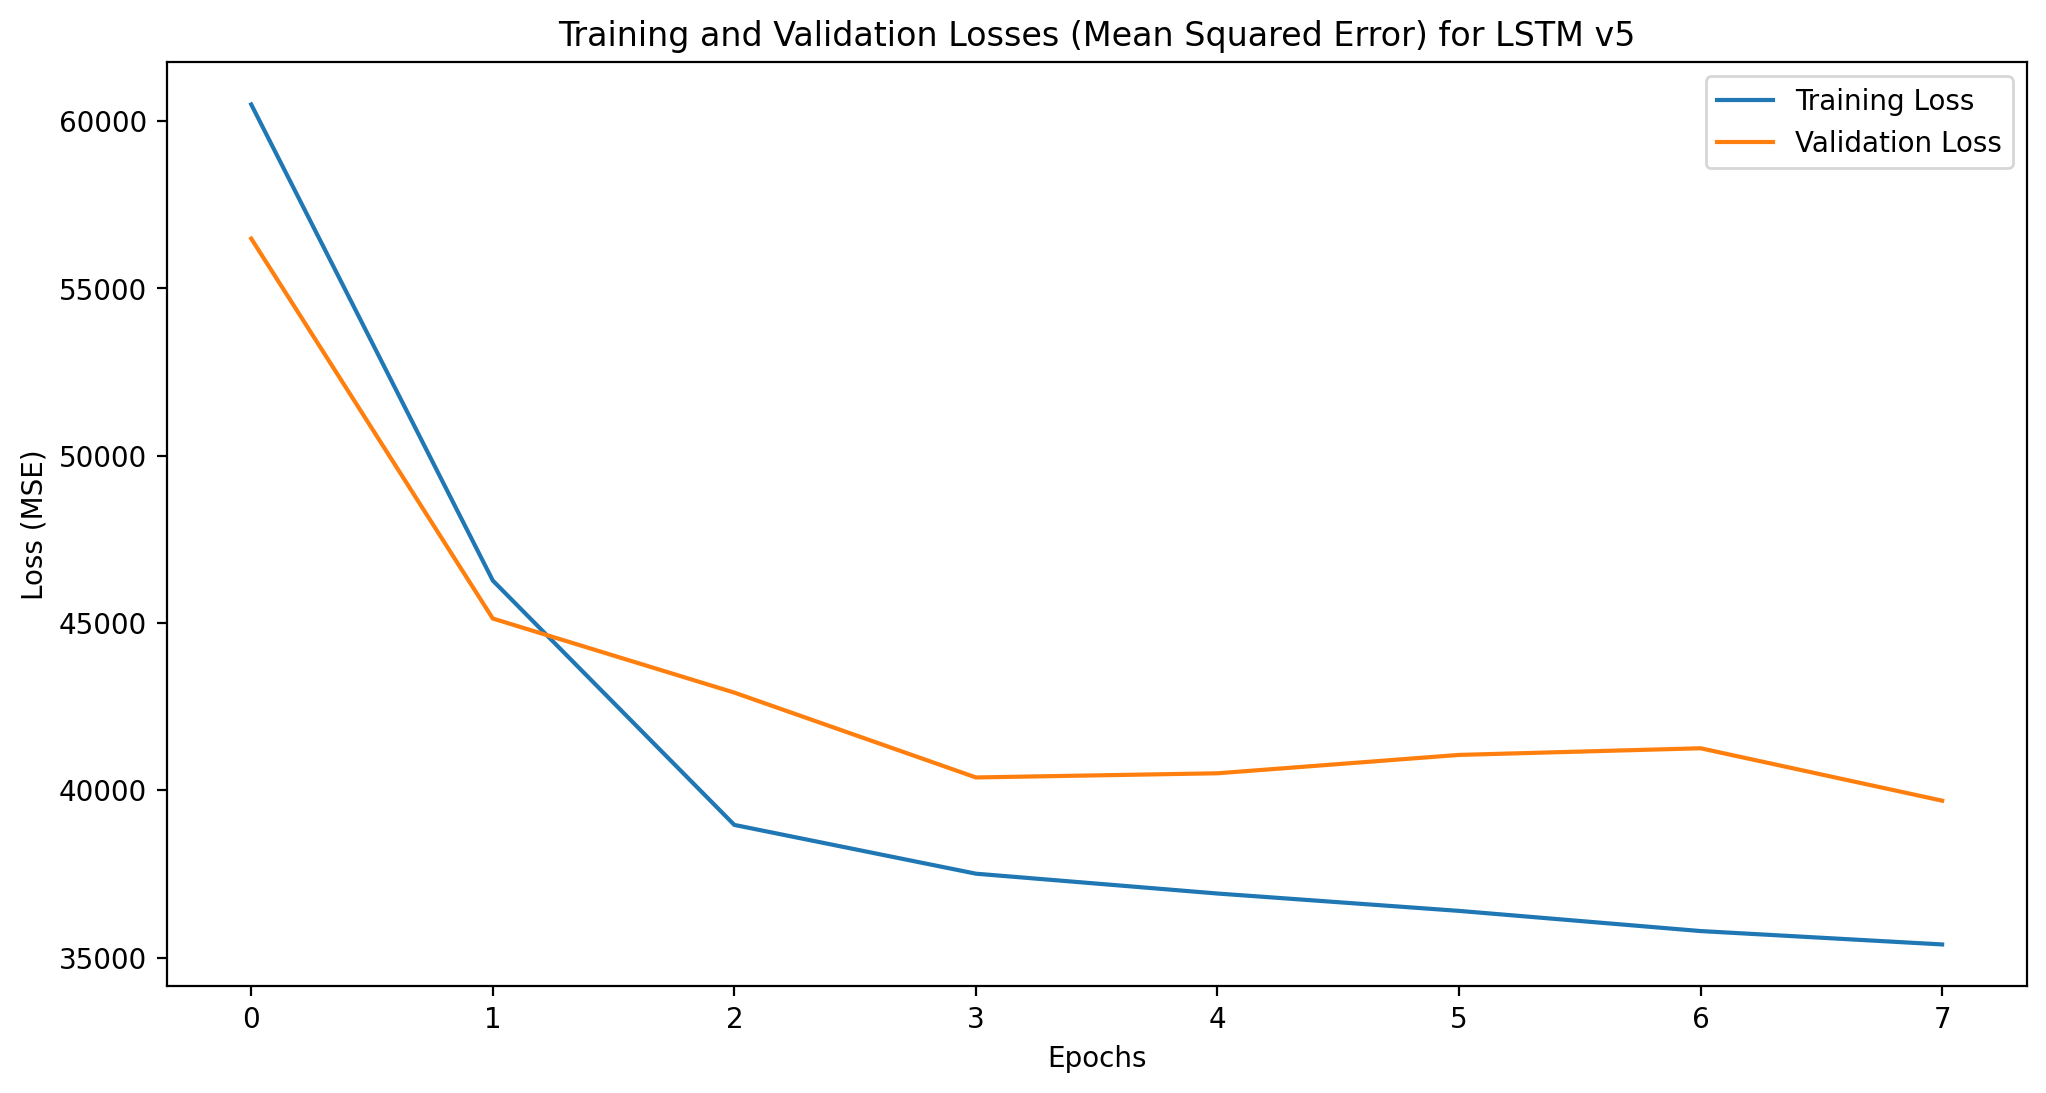

In [19]:
if type(history) == tf.keras.callbacks.History:
    history = history.history
    
plt.figure(figsize=(12, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title(f'Training and Validation Losses (Mean Squared Error) for LSTM v{MODEL_VERSION}')
plt.legend()
plt.savefig(f'../../output/model_validation/loss_curves_train_val_v{MODEL_VERSION}.png', bbox_inches='tight')
plt.show()

In [39]:
best_epoch = history['val_loss'].index(min(history['val_loss']))  # Add 1 because epochs are 1-indexed
print(f"Best validation loss came at epoch {best_epoch} (0-indexed) with a validation loss of val_loss={min(history['val_loss'])}")

Best validation loss came at epoch 7 (0-indexed) with a validation loss of val_loss=39689.05859375


## b. Long-term forecasting [v4]

Make predictions on the test set

In [153]:
y_pred = model.predict(X_test)

16335/16335 [==============================] - 24s 1ms/step


Calculate Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE)

In [154]:
rmse = sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

Root Mean Squared Error (RMSE): 197.53945644902106
Mean Absolute Error (MAE): 127.58221355681061


Plot actual VS forecasted values

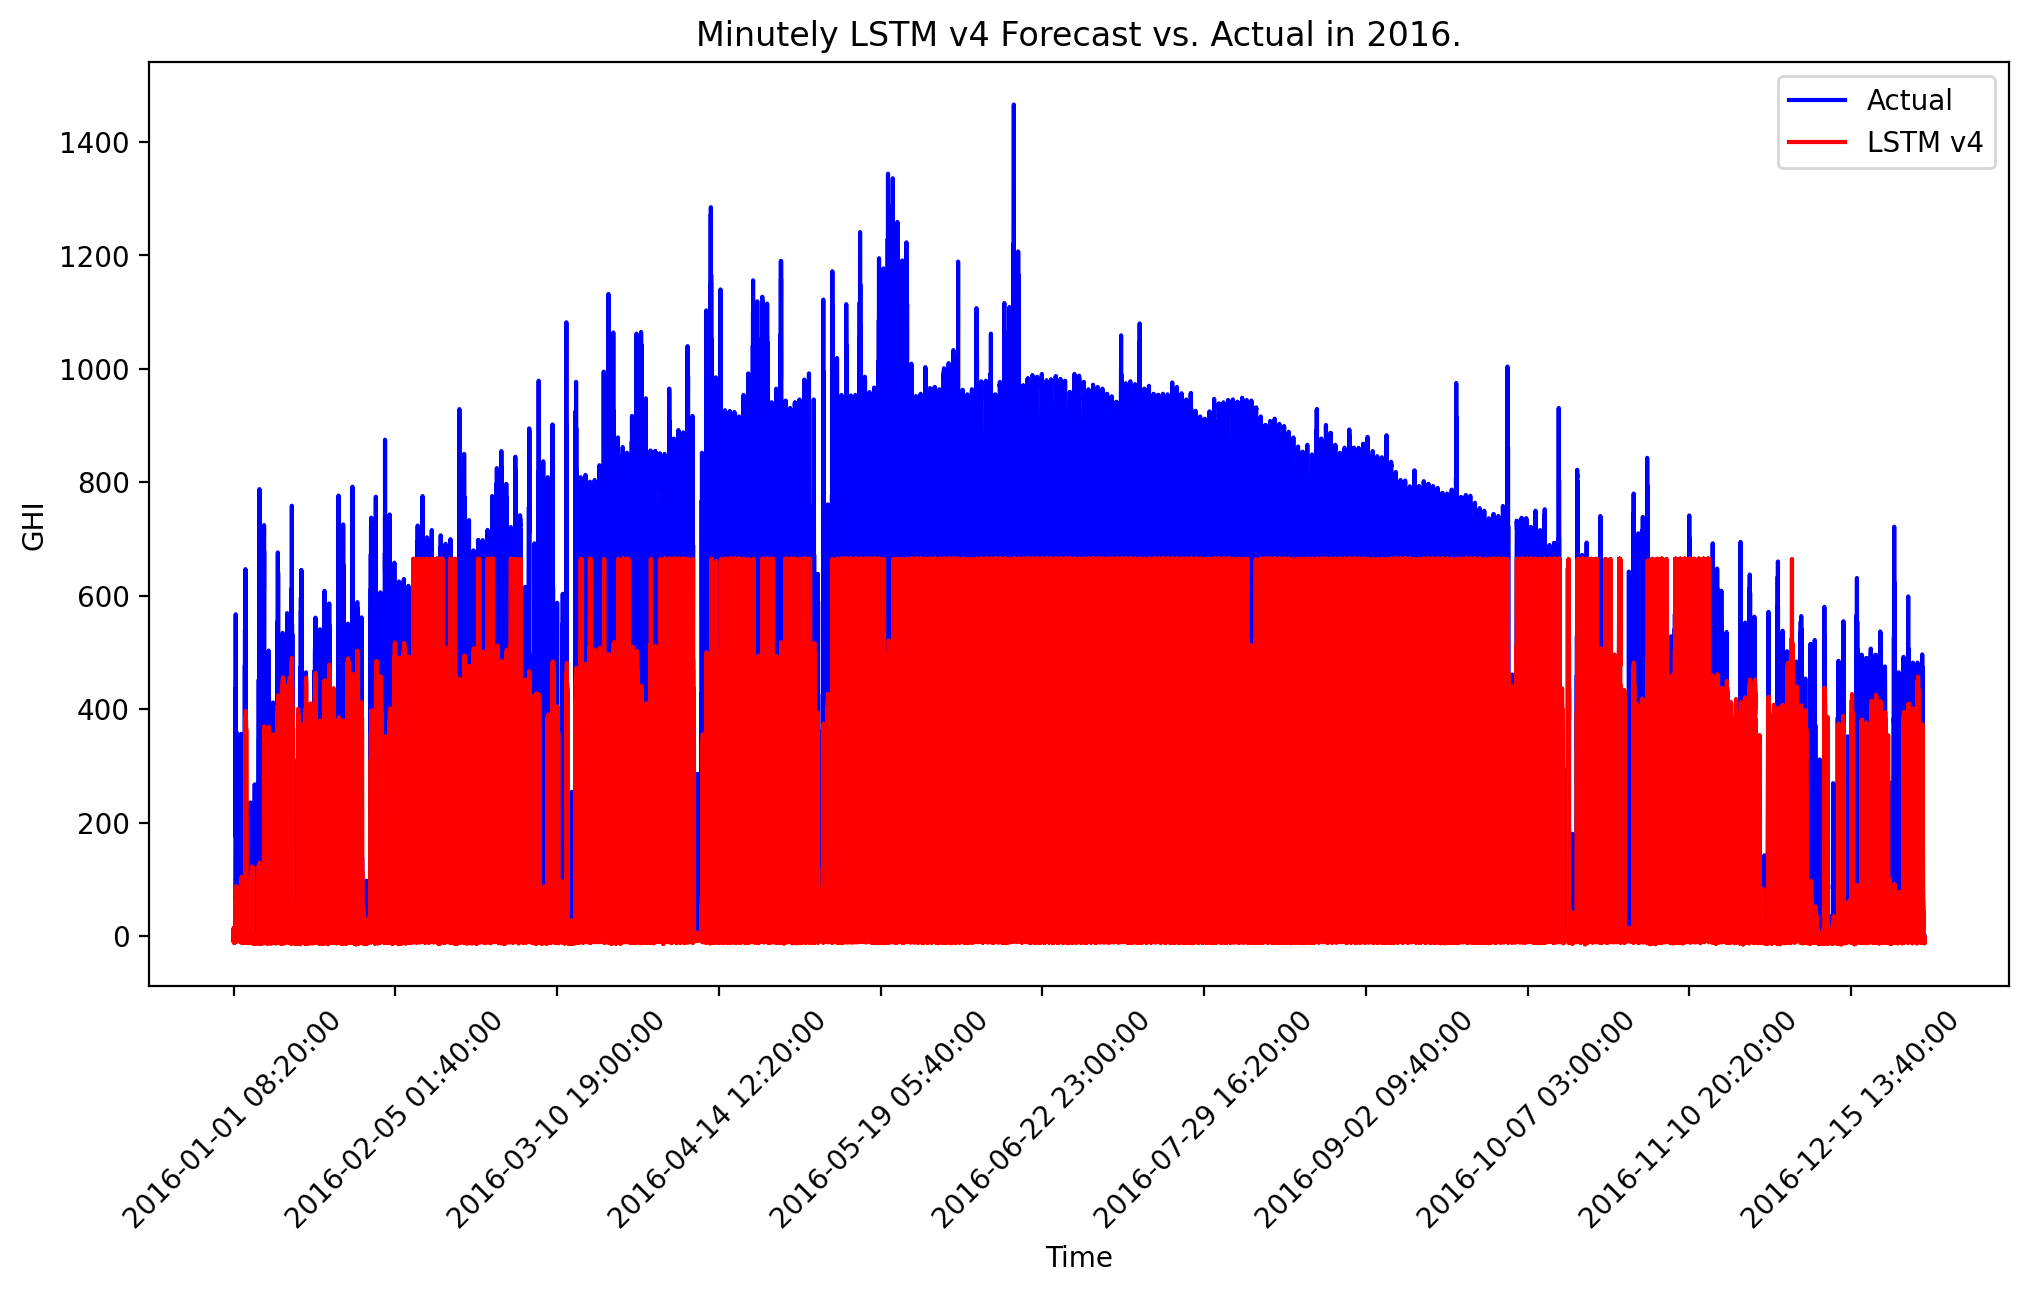

In [155]:
data_values = df_test["timeStamp"]
formatted_date_list = [d.strftime("%m-%Y") for d in data_values]
interval = 50000

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', color='b')
plt.plot(y_pred, label='LSTM v4', color='r')
plt.xlabel('Time')
plt.ylabel('GHI')
plt.xticks(range(0, len(data_values), interval), data_values[::interval], rotation=45)
plt.title(f'Minutely LSTM v{MODEL_VERSION} Forecast vs. Actual in 2016.')
plt.savefig(f"../../output/model_validation/lstm_v{MODEL_VERSION}_forecast_vs_actual.png", bbox_inches='tight')
plt.legend()
plt.show()

In [164]:
group_data

,timeStamp,ghi,air_temp,relhum,press,windsp,winddir,max_windsp,precipitation,air_temp_lag_10m,relhum_lag_10m,press_lag_10m,windsp_lag_10m,winddir_lag_10m,max_windsp_lag_10m,precipitation_lag_10m,air_temp_lag_20m,relhum_lag_20m,press_lag_20m,windsp_lag_20m,winddir_lag_20m,max_windsp_lag_20m,precipitation_lag_20m,persistence_forecast,Actual,Month
1508640,2016-12-01 00:00:00,31.950,12.700,62.340,1007.000,0.940,298.300,1.800,0.000,12.700,62.600,1007.000,0.460,238.600,0.900,0.000,12.600,63.760,1007.000,1.700,288.000,2.600,0.000,87.200,30.470,12-2016
1508641,2016-12-01 00:01:00,30.470,12.700,62.240,1007.000,1.520,308.200,1.900,0.000,12.700,62.440,1007.000,1.020,267.300,2.000,0.000,12.600,63.520,1007.000,1.760,286.800,2.400,0.000,85.700,29.430,12-2016
1508642,2016-12-01 00:02:00,29.430,12.620,62.320,1007.000,1.280,307.400,1.800,0.000,12.700,62.160,1007.000,1.320,290.400,1.900,0.000,12.600,63.460,1007.000,1.340,277.000,1.800,0.000,83.700,28.480,12-2016
1508643,2016-12-01 00:03:00,28.480,12.600,62.620,1007.000,1.000,312.600,1.500,0.000,12.700,62.140,1007.000,1.060,288.600,1.500,0.000,12.600,63.920,1007.000,0.880,258.100,1.100,0.000,81.200,27.240,12-2016
1508644,2016-12-01 00:04:00,27.240,12.600,62.920,1007.000,1.080,306.400,1.400,0.000,12.700,61.880,1007.000,1.140,283.500,1.800,0.000,12.600,63.940,1007.000,1.140,267.000,1.700,0.000,78.000,25.950,12-2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552314,2016-12-31 07:54:00,0.000,7.520,85.600,1001.000,2.360,204.800,4.300,0.000,7.280,84.400,1001.000,2.380,194.000,3.400,0.000,7.100,84.300,1001.000,2.140,178.300,4.700,0.000,0.000,0.000,12-2016
1552315,2016-12-31 07:55:00,0.000,7.600,85.600,1001.000,1.280,237.100,2.200,0.000,7.300,84.500,1001.000,1.960,188.000,3.700,0.000,7.100,84.200,1001.000,2.040,214.300,4.600,0.000,0.000,0.000,12-2016
1552316,2016-12-31 07:56:00,0.000,7.600,85.800,1000.000,3.460,171.200,6.800,0.000,7.300,84.500,1001.000,1.640,172.900,2.500,0.000,7.100,84.400,1001.000,2.560,191.300,5.600,0.000,0.000,0.000,12-2016
1552317,2016-12-31 07:57:00,0.000,7.700,86.100,1001.000,1.380,213.200,2.800,0.000,7.300,84.800,1001.000,1.320,152.600,2.100,0.000,7.160,84.400,1001.000,2.740,198.800,5.300,0.000,0.000,0.000,12-2016


## c. Fine-Tuning (Hyperparameter optimisation)


To fine-tune:
- number of nodes (25, 50, 75, 100, 125, 150)
- optimizer learning rate (0.001, 0. 01. 0.1)
- additional hidden layers? (1, 2, 3)
- batch size (1, 2, 16, 32, 64)
- dropout?
- epochs?

In [99]:
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int('num_layers', min_value=1, max_value=3)):
        model.add(LSTM(units=hp.Int(f'lstm_{i}_units', min_value=25, max_value=150, step=25),
                       activation='tanh',
                       recurrent_activation='sigmoid',
                       use_bias=True,
                       return_sequences=True))
    model.add(Dense(1))

    # Set the learning rate as a hyperparameter
    optimiser = Adam(learning_rate=hp.Choice('learning_rate', values=[0.001, 0.01, 0.1]))
    model.compile(optimizer=optimiser, 
                  loss='mean_squared_error', 
                  metrics=['mean_absolute_error', root_mean_squared_error])

    return model

In [115]:
# Add early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor="val_loss", 
                               patience=3, 
                               restore_best_weights=True,
                               verbose=1)

# Perform the hyperparameter search with early stopping
results_df = pd.DataFrame(columns=['lstm_0_units', "lstm_1_units", "lstm_2_units", 'num_layers', 'learning_rate', 'val_loss'])
for i in range(25):
    tuner = RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=1,  # Number of combinations to try
        directory='../../output/lstm_keras_tuning/',
        project_name=f'lstm_v3_iter{i}',
        overwrite=True,
    )
    
    tuner.search(X_train, 
             y_train, 
             epochs=50, 
             batch_size=32, 
             verbose=1, 
             validation_data=(X_val, y_val),
             callbacks=[early_stopping])

    # Get the best hyperparameters for this iteration
    completed_trials = tuner.oracle.get_best_trials(num_trials=1)
    if completed_trials:
        best_hps = completed_trials[0].hyperparameters
        best_val_loss = completed_trials[0].score

    # Append the results to the DataFrame
    dict_results = dict()
    dict_results["num_layers"] = best_hps.get("num_layers")
    dict_results["learning_rate"] = best_hps.get("learning_rate")
    dict_results["val_loss"] = best_val_loss
    for nl in range(0, dict_results["num_layers"]):
        dict_results[f"lstm_{nl}_units"] = best_hps.get("num_layers")
    results_df = pd.concat([results_df, pd.DataFrame.from_records([dict_results])])

# Save the results DataFrame as a CSV file
results_df.to_csv('../../output/lstm_random_gs_results.csv', index=False)
results_df

In [30]:
df_gs_results = pd.read_csv("../../output/lstm_random_gs_results.csv").set_index("Iteration").sort_values(by="val_loss", ascending=True)
df_gs_results

,num_layers,lstm_0_units,lstm_1_units,lstm_2_units,Dropout,learning_rate,val_loss,best_epoch (0-index)
Iteration,,,,,,,,
7,1,30,NaN,NaN,0.100,0.001,39346.113,3.000
1,1,30,NaN,NaN,NaN,0.001,40490.805,3.000
6,1,32,NaN,NaN,0.200,0.001,45841.367,9.000
5,3,125,25.000,25.000,NaN,0.010,45981.934,1.000
2,1,50,NaN,NaN,NaN,0.010,46449.129,NaN
3,2,50,25.000,NaN,NaN,0.001,46606.363,NaN
4,2,75,25.000,NaN,NaN,0.100,55704.758,4.000


Best model:

In [31]:
df_gs_results.iloc[0].to_dict()

{'num_layers': 1.0,
 'lstm_0_units': 30.0,
 'lstm_1_units': nan,
 'lstm_2_units': nan,
 'Dropout': 0.1,
 'learning_rate': 0.001,
 'val_loss': 39346.11328125,
 'best_epoch (0-index)': 3.0}

# 5. Short-Term forecasting

## a. Sequence Model [v5]

In [15]:
MODEL_VERSION = "5"
is_train_new_model = True

Define the LSTM model.


In [16]:
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def lstm_model():
    # Define layers
    model = Sequential()
    model.add(LSTM(units=30, 
                   kernel_regularizer=l2(0.01), # add some L2 to discourage learning complex patterns by penalising loss function
                   return_sequences=True, # return single GHI value, not the sequence of values
                   activation='tanh',
                   recurrent_activation='sigmoid',
                   use_bias=True,
                   stateful=False,
                   input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(rate=0.10))
    model.add(Dense(1))
    
    # Define optimiser
    optimiser = Adam(learning_rate=0.01)
    model.compile(optimizer=optimiser, 
                  loss='mean_squared_error', 
                  metrics=['mean_absolute_error', root_mean_squared_error])
    
    return model

# Create LSTM model
model = lstm_model()
model.summary()

2023-09-06 20:42:23.601333: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-06 20:42:23.601748: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-06 20:42:23.602483: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-06 20:42:23.603074: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so ret

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 21, 30)            3840      
                                                                 
 dropout (Dropout)           (None, 21, 30)            0         
                                                                 
 dense (Dense)               (None, 21, 1)             31        
                                                                 
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________


Optional: restore the weights or train a new model

In [17]:
model.load_weights(f'../../output/lstm_models/lstm_v{MODEL_VERSION}.h5')
is_train_new_model = False

Train model

In [18]:
# Add early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor="val_root_mean_squared_error", 
                               patience=3, 
                               restore_best_weights=True,
                               mode="min")
csv_logger = CSVLogger(f'../../output/lstm_history/training_log_v{MODEL_VERSION}.csv', separator=',', append=False)

if is_train_new_model:
    print(f"Training a new LSTM model (version {MODEL_VERSION}).")
    history = model.fit(X_train, 
                        y_train, 
                        epochs=50,  # max number of epochs
                        batch_size=32, 
                        verbose=1, 
                        validation_data=(X_val, y_val), 
                        callbacks=[early_stopping, csv_logger])
    # Save fitted model and history
    model.save(f"../../output/lstm_models/lstm_v{MODEL_VERSION}.h5")
    with open(f"../../output/lstm_history/training_history_v{MODEL_VERSION}.pkl", "wb") as f:
        pickle.dump(history.history, f)
    
else:
    print(f"Re-loading previously trained LSTM model history (version {MODEL_VERSION}).")
    with open(f'../../output/lstm_history/training_history_v{MODEL_VERSION}.pkl', 'rb') as history_file:
        history = pickle.load(history_file)

Re-loading previously trained LSTM model history (version 5).


Plot training loss and validation loss

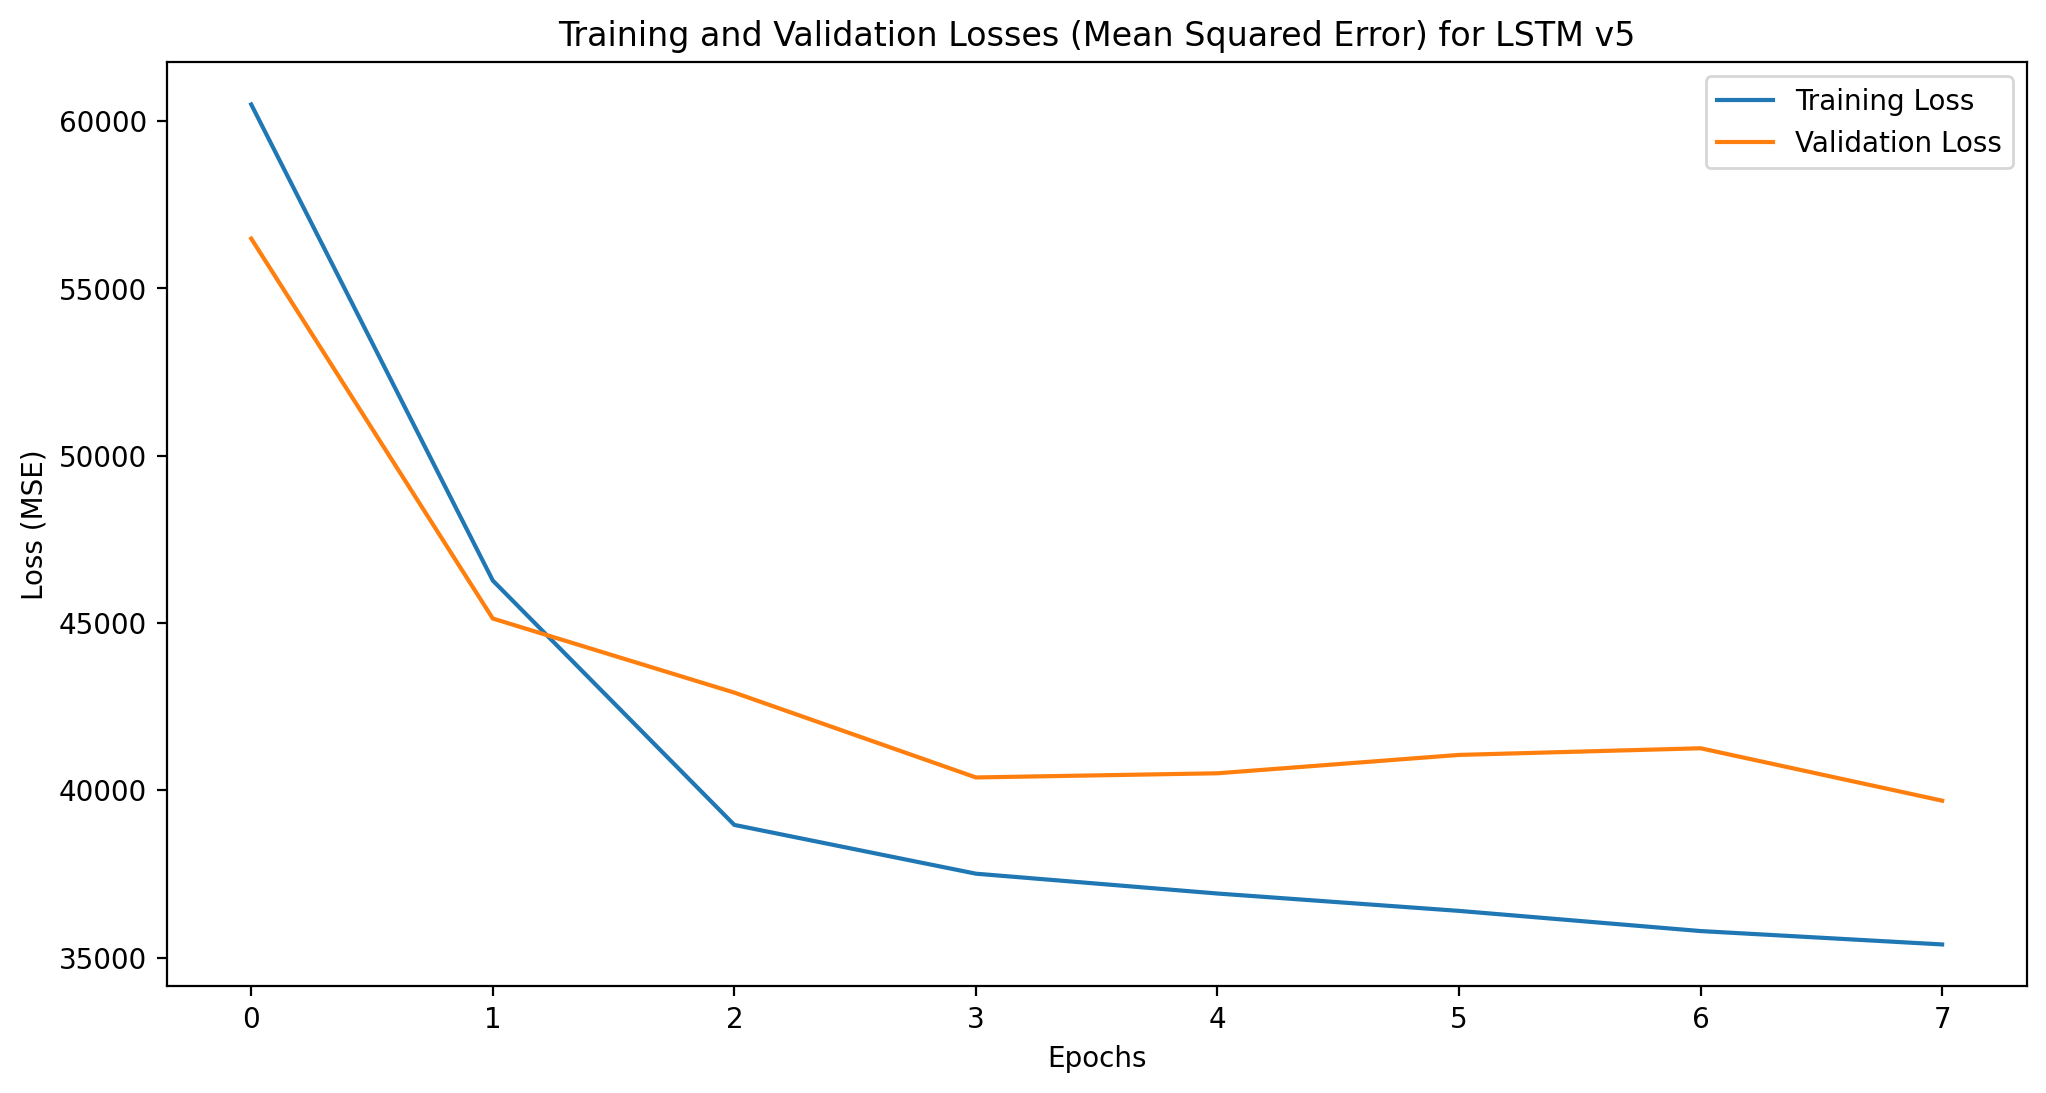

In [19]:
if type(history) == tf.keras.callbacks.History:
    history = history.history
    
plt.figure(figsize=(12, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title(f'Training and Validation Losses (Mean Squared Error) for LSTM v{MODEL_VERSION}')
plt.legend()
plt.savefig(f'../../output/model_validation/loss_curves_train_val_v{MODEL_VERSION}.png', bbox_inches='tight')
plt.show()

In [20]:
best_epoch = history['val_loss'].index(min(history['val_loss']))  # Add 1 because epochs are 1-indexed
print(f"Best validation loss came at epoch {best_epoch} (0-indexed) with a validation loss of val_loss={min(history['val_loss'])}")

Best validation loss came at epoch 7 (0-indexed) with a validation loss of val_loss=39689.05859375


## b. Short-term forecasting (20-minute horizon) [v5]

reset

In [49]:
df_test = df_fe.loc[df_fe["timeStamp"] >= test_start]
X_test_tmp = X_test.copy()

20-minute horizon over whole df

In [50]:
# Create a list to store RMSE values for each horizon
rmse_values_lstm = list()

# Define the prediction horizon (in minutes)
prediction_horizon = 20  # 20 minutes

# Iterate through the DataFrame to calculate RMSE for each horizon
for horizon in range(1, prediction_horizon + 1):
    X_test_tmp = X_test_tmp[:-horizon]  # Adjust length by removing horizon elements
    
    # Shift the actual values by the horizon to match the LSTM model's predictions
    df_test['Actual'] = df_test['ghi'].shift(-horizon)
    
    # Drop rows with NaN values (due to shifting)
    df_test.dropna(inplace=True)
    
    # Make predictions using your LSTM model
    lstm_predictions = model.predict(X_test_tmp)
    
    # Calculate RMSE for this horizon
    rmse = np.sqrt(mean_squared_error(df_test['Actual'], lstm_predictions))
    rmse_values_lstm.append(rmse)

16329/16329 [==============================] - 24s 1ms/step


Persistence

In [51]:
rmse_values_persistence = list()

# Iterate through the data to calculate RMSE for each horizon
for horizon in range(1, prediction_horizon + 1):
    # Shift the actual values by the horizon to simulate a persistence forecast
    df_test['persistence_forecast'] = df_test['ghi'].shift(horizon)
    
    # Calculate RMSE for this horizon
    rmse = np.sqrt(np.mean((df_test['ghi'] - df_test['persistence_forecast'])**2))
    rmse_values_persistence.append(rmse)

Plot

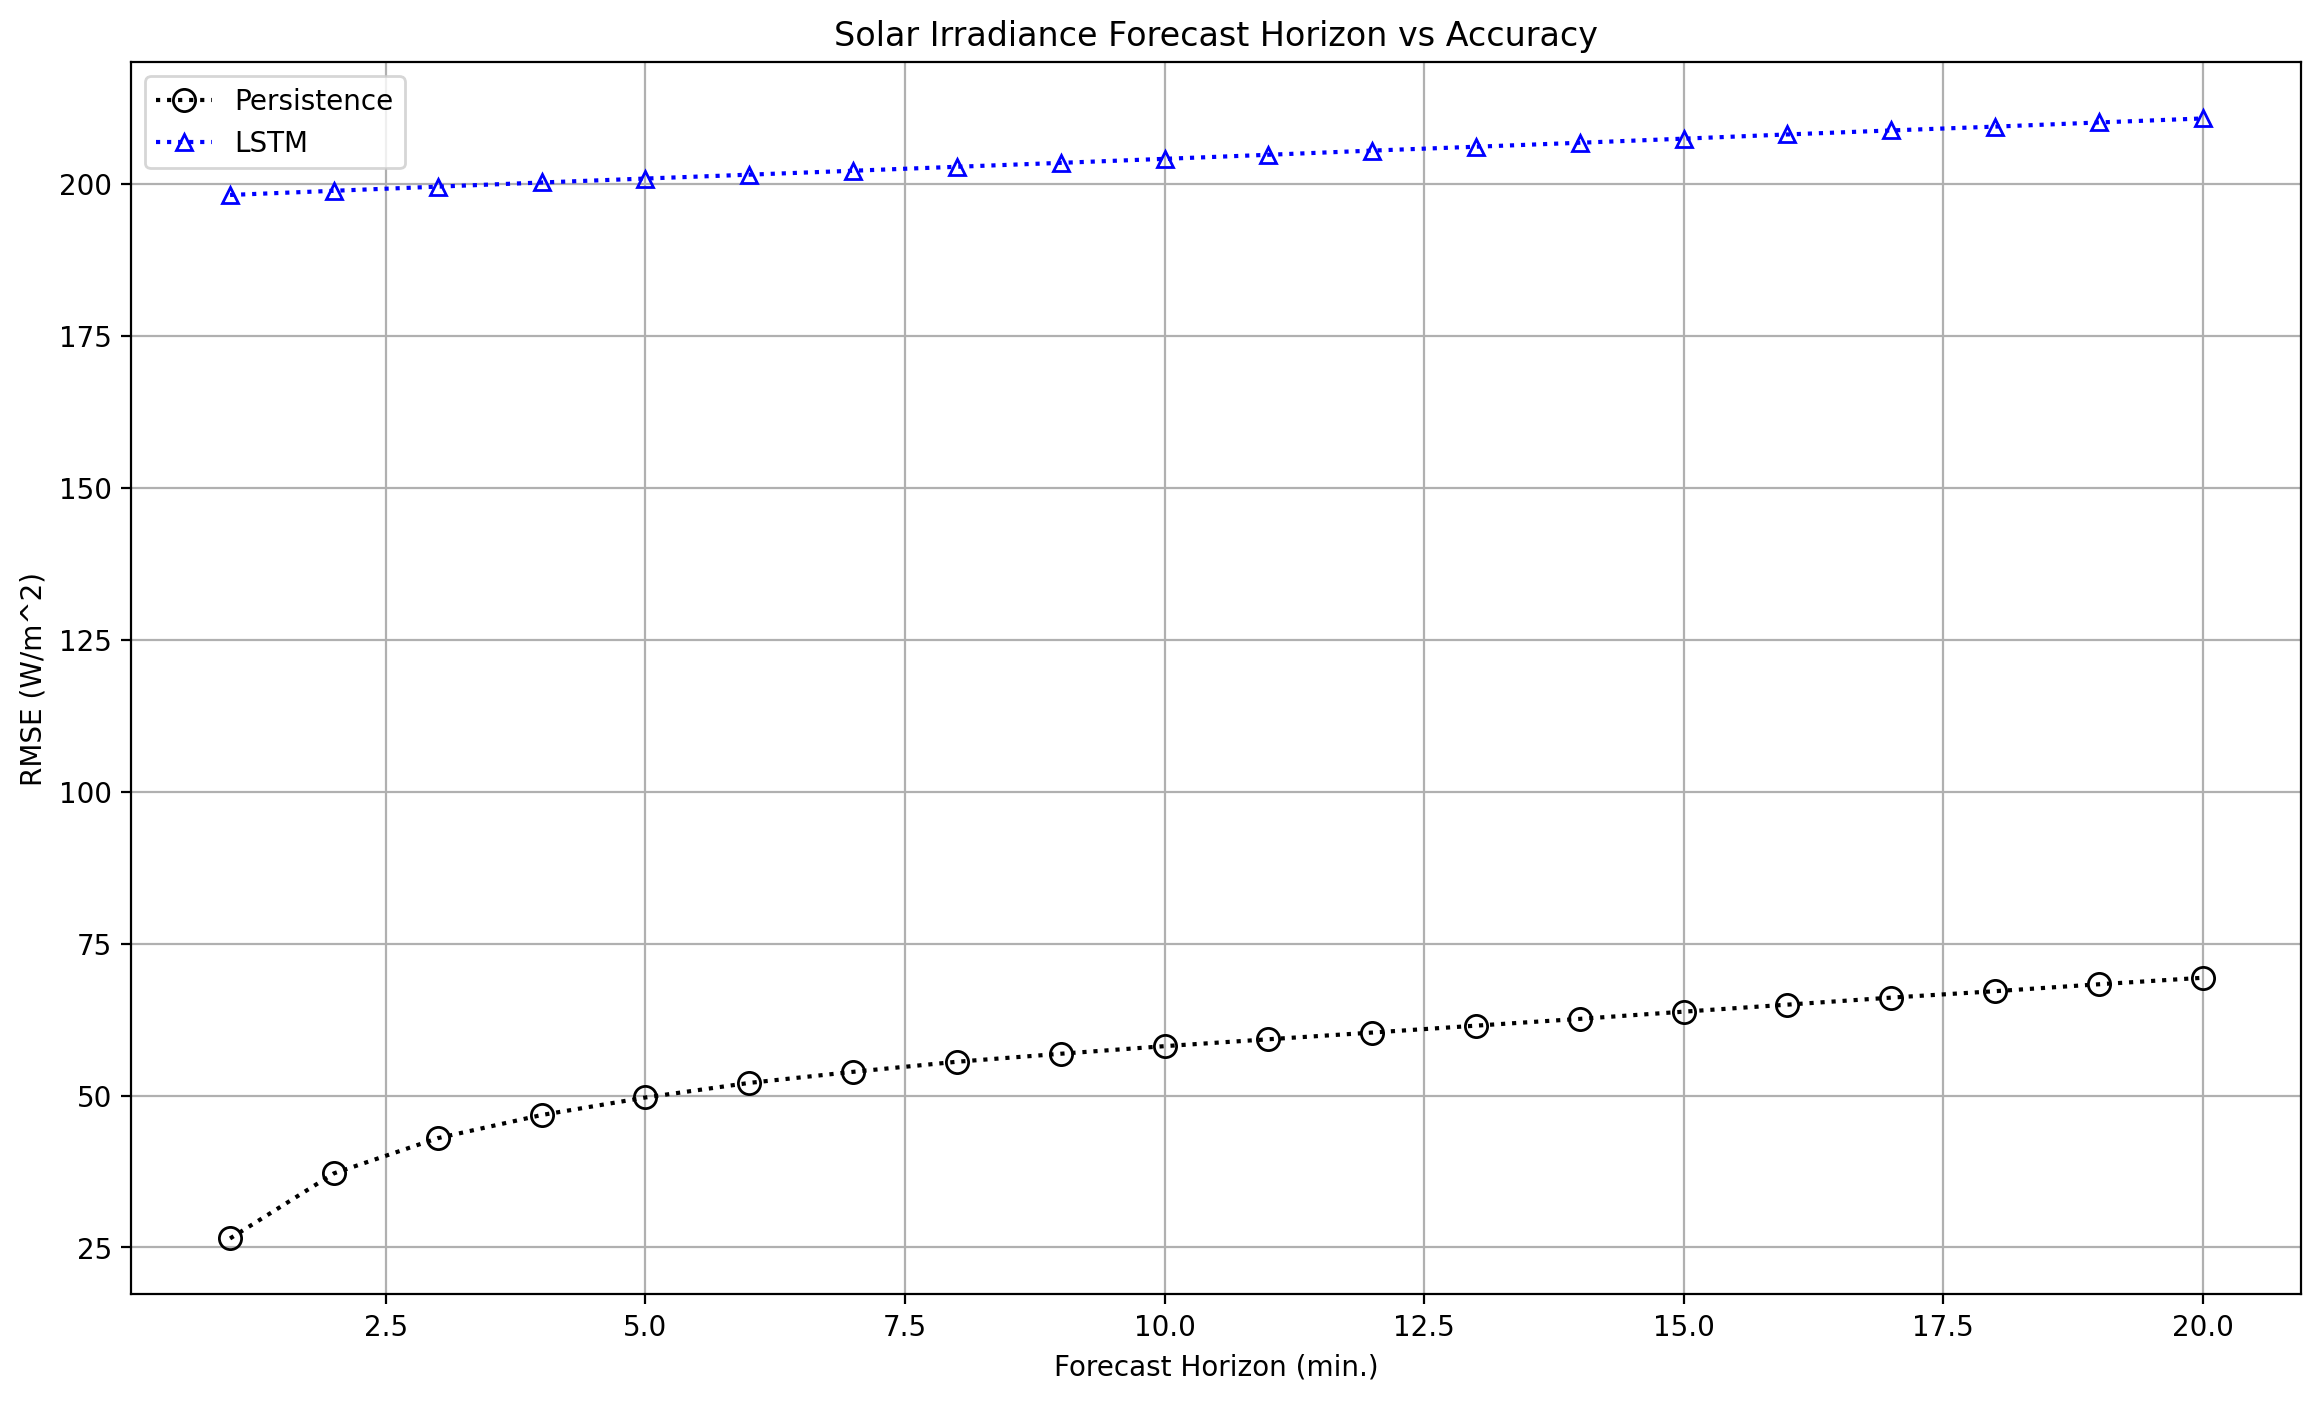

In [57]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(range(1, prediction_horizon + 1), rmse_values_persistence, label='Persistence', 
        color='black', linestyle="dotted", marker='o', markerfacecolor='none', markersize=8)
ax.plot(range(1, prediction_horizon + 1), rmse_values_lstm, label='LSTM', 
        color='blue', linestyle="dotted", marker='^', markerfacecolor='none', markersize=6)

plt.xlabel('Forecast Horizon (min.)')
plt.ylabel('RMSE (W/m^2)')
plt.title('Solar Irradiance Forecast Horizon vs Accuracy')
plt.legend()
plt.grid(True)
plt.savefig("../../output/model_validation/lstm_20m_horizon.png", bbox_inches='tight')
plt.show()

# Appendix

Attempt at merging sky features

In [12]:
df_sky_img_features = pd.read_csv("../data/Folsom_sky_image_features.csv", infer_datetime_format=True)
df_sky_img_features = df_sky_img_features.rename(columns={"timestamp": "timeStamp"})
df_sky_img_features

,timeStamp,AVG(R),STD(R),ENT(R),AVG(G),STD(G),ENT(G),AVG(B),STD(B),ENT(B),AVG(RB),STD(RB),ENT(RB),AVG(NRB),STD(NRB),ENT(NRB)
0,2014-01-01 00:00:11,102.8933,45.8083,5.6373,121.5468,39.5426,5.6390,133.4322,30.8409,5.4275,0.7457,0.1647,4.8206,-0.1554,0.1033,4.2279
1,2014-01-01 00:01:10,109.1193,44.9516,5.6762,128.0568,38.7453,5.6535,139.4049,30.2546,5.4146,0.7601,0.1547,4.7120,-0.1447,0.0953,4.0961
2,2014-01-01 00:02:10,118.4310,44.4158,5.6386,129.2313,39.1756,5.6381,134.9957,30.8004,5.4368,0.8591,0.1453,4.7299,-0.0822,0.0821,3.9662
3,2014-01-01 00:03:11,108.0799,46.3934,5.6447,129.5778,39.5050,5.6392,142.6288,30.9485,5.4369,0.7347,0.1625,4.8007,-0.1626,0.1034,4.2324
4,2014-01-01 00:04:11,106.7813,45.5549,5.6539,126.3533,39.0664,5.6438,137.2983,30.4596,5.4168,0.7541,0.1613,4.7906,-0.1494,0.1003,4.1823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775911,2016-12-31 23:55:59,119.0850,58.5266,6.1185,120.1349,55.4199,6.0586,121.2516,46.8522,5.8533,0.9560,0.1625,4.8787,-0.0299,0.0901,4.0444
775912,2016-12-31 23:57:00,118.1933,59.0074,6.0942,119.7764,55.4268,6.0228,119.8126,46.1397,5.8002,0.9598,0.1788,5.0047,-0.0295,0.0987,4.1621
775913,2016-12-31 23:57:59,117.1289,59.2942,6.0814,119.1408,55.3043,6.0002,120.5959,45.5852,5.7543,0.9429,0.1899,5.0979,-0.0398,0.1066,4.2562
775914,2016-12-31 23:58:59,110.1486,61.0436,6.0823,116.9210,55.7548,6.0016,124.4827,45.2933,5.7811,0.8445,0.2123,5.1260,-0.0995,0.1323,4.4107


In [15]:
df_1 = df.merge(df_sky_img_features, on="timeStamp", how="left", indicator=True)

In [32]:
df_1["_merge"].value_counts()


left_only     1272457
both           279863
right_only          0
Name: _merge, dtype: int64